### Exploring dataset categories

In [1]:
#!pip install -U sentence-transformers

In [2]:
import pandas as pd
import numpy as np
#from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm.notebook import tqdm
import warnings
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
df_chats = pd.read_csv("unique_chats.csv")

In [4]:
print(df_chats.shape)

(1861615, 5)


In [5]:
print("1% of the dataset:")
int(df_chats.shape[0] * 0.01)

1% of the dataset:


18616

### SUBSAMPLING

In [6]:
# Vamos amostrar ~ 2% do dataset
SAMPLE_SIZE = 40000

df_chats = df_chats.sample(n=SAMPLE_SIZE, random_state=42)

In [7]:
df_chats.dropna(subset=['content'], inplace=True)
df_chats.shape

(39999, 5)

In [8]:
model = None

sentences = df_chats['content'].tolist()

model_list = [
    'sentence-transformers/all-MiniLM-L6-v2', # modelo generico multilingual
    'neuralmind/bert-base-portuguese-cased', # BERTimbau Base (aka "bert-base-portuguese-cased")
    'paraphrase-multilingual-mpnet-base-v2', # multilingual com vetor de 768
]

model = SentenceTransformer(model_list[1])

embedding_matrix = model.encode(
    sentences,
    batch_size=32,  # Adjust for low GPU memory
    show_progress_bar=True,
    convert_to_numpy=True,   # Returns numpy array
    normalize_embeddings=False  # Set to True for L2 normalized embeddings
)

embedding_matrix

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

array([[-0.33381334,  0.00175331, -0.03479509, ..., -0.05662391,
         0.49150467, -0.396279  ],
       [-0.36658353, -0.05322446,  0.12176383, ...,  0.23335087,
         0.3839119 , -0.5185142 ],
       [-0.26640397,  0.02242502,  0.01742476, ..., -0.07874986,
         0.54208636, -0.45152536],
       ...,
       [-0.33946136,  0.06737844, -0.07594451, ...,  0.05830875,
         0.5427899 , -0.5282596 ],
       [-0.41470438, -0.058803  ,  0.21298501, ...,  0.32033044,
         0.2964269 , -0.47240672],
       [-0.47182497, -0.02020342,  0.28360912, ...,  0.2589116 ,
         0.34210122, -0.43172243]], dtype=float32)

In [9]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [10]:
print(f"embedding matrix shape: {embedding_matrix.shape}")

embedding matrix shape: (39999, 768)


Finding optimal number of clusters...


  0%|          | 0/12 [00:00<?, ?it/s]

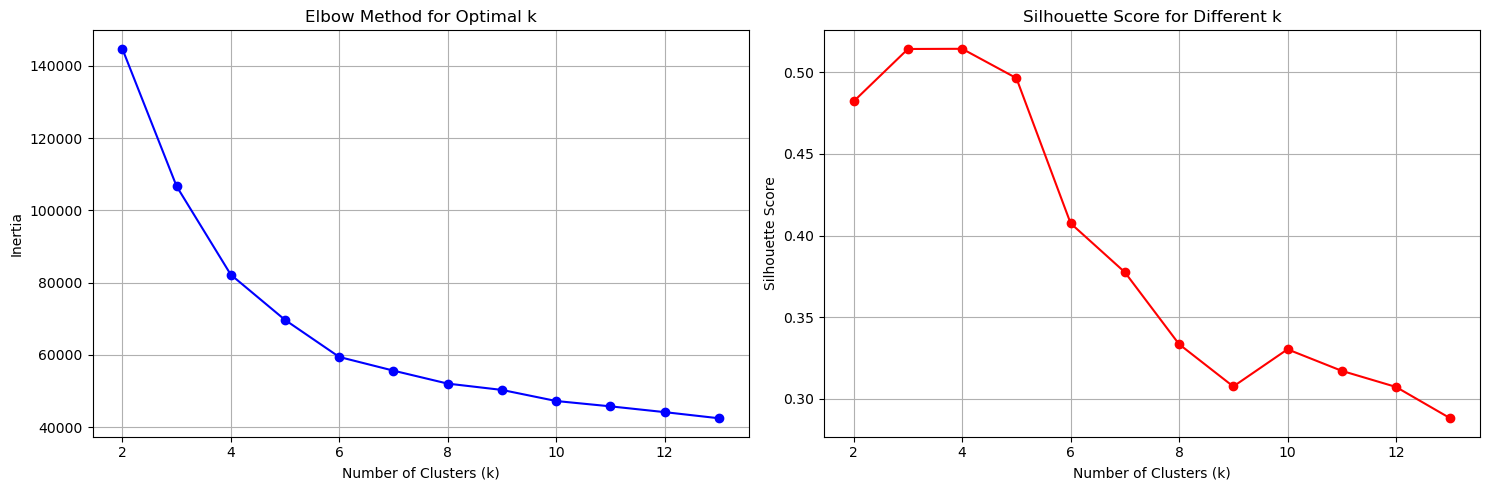

In [11]:
# Elbow method
print("Finding optimal number of clusters...")
inertias = []
silhouette_scores = []
k_range = range(2, 14)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embedding_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embedding_matrix, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

3 possui a maior Silhouette score

além disso, é o ponto de "desaceleração" da inercia

In [12]:
BREAK

NameError: name 'BREAK' is not defined

In [13]:
n_clusters = 3

In [14]:
### 

In [15]:
# Perform final clustering with specified number of clusters
print(f"Performing K-means clustering with {n_clusters} clusters...")
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(embedding_matrix)

# Add cluster labels to dataframe
df_chats['cluster'] = cluster_labels

# Calculate silhouette score for final clustering
final_silhouette = silhouette_score(embedding_matrix, cluster_labels)
print(f"Final silhouette score: {final_silhouette:.3f}")


Performing K-means clustering with 3 clusters...
Final silhouette score: 0.514



Cluster Analysis:

Cluster 0 (12436 messages):
------------------------------
Sample messages:
  1. Porque não consigo tira a foto?
##################################################
Prezado(a) Cidadã...
  2. Como entrar no repiscidadao
##################################################
Prezado(a) Cidadão(ã)...
  3. Gostaria de saber uma informação que consta em minha carteira digital 
#############################...

Cluster 1 (23422 messages):
------------------------------
Sample messages:
  1. Não consigo acessar minha conta gov por que mudei de telefone 
#####################################...
  2. Quero o acesso novamente 
##################################################
Olá! Você está no Chat ...
  3. Não consigo tirar foto da erro 
##################################################
Olá! Você está no...

Cluster 2 (4141 messages):
------------------------------
Sample messages:
  1. Tirar o acesso em duas etapas 
##################################################
Olá! Você 

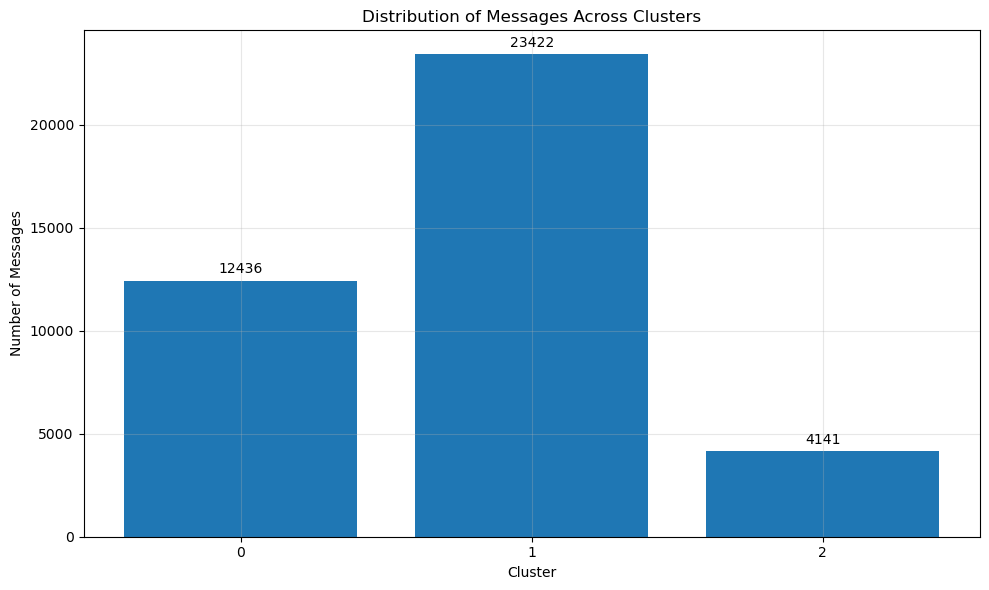

In [16]:
# Analyze clusters
print("\nCluster Analysis:")
print("="*50)

for i in range(n_clusters):
    cluster_texts = df_chats[df_chats['cluster'] == i]['content']
    print(f"\nCluster {i} ({len(cluster_texts)} messages):")
    print("-" * 30)
    
    # Get top terms for this cluster
    cluster_center = kmeans_final.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    
    # Show sample messages from this cluster
    sample_messages = cluster_texts.head(3).tolist()
    print("Sample messages:")
    for j, msg in enumerate(sample_messages, 1):
        print(f"  {j}. {msg[:100]}...")

# Create cluster distribution plot
plt.figure(figsize=(10, 6))
cluster_counts = Counter(cluster_labels)
clusters = list(cluster_counts.keys())
counts = list(cluster_counts.values())

plt.bar(clusters, counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Messages')
plt.title('Distribution of Messages Across Clusters')
plt.xticks(clusters)
plt.grid(True, alpha=0.3)

for cluster_id, count in zip(clusters, counts):
    plt.text(cluster_id, count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Cluster visualization

In [17]:
from visualizations import create_3d_cluster_visualization, create_2d_comparison_plots, analyze_cluster_separation

In [18]:
df_chats[(df_chats['content'] == "1")]

Unnamed: 0                     conversation_uuid  \
1784610     1784610  f5729994-cda2-405b-897b-792d75cb18e2   
1572491     1572491  d83c51aa-ab0e-41c4-9413-ad2e944fa32a   
947389       947389  825741a0-6a0b-4e0b-919e-50e11a45ce41   
1312521     1312521  b4855162-b235-435e-8a98-f3c78cbfd75f   
1540699     1540699  d3ddc7bc-ca0b-4efc-9ea8-0932365453cc   
430207       430207  3b2f5967-439a-443a-92dc-4809793211df   

                                         name   author content  cluster  
1784610                         Fabio Camacho  CONTACT       1        2  
1572491  Alessandra coelho da Silva Oliveira   CONTACT       1        2  
947389                  ROBSON GARRRIDOCALDAS  CONTACT       1        2  
1312521                   neusa maria martins  CONTACT       1        2  
1540699              Edna Maria Soares Silva   CONTACT       1        2  
430207                 Reginaldo Mota Simões   CONTACT       1        2

In [19]:
# df_chats = df_chats.drop(df_chats[(df_chats['content'] == "1")].index)

In [20]:
tsne_coords, pca_coords = create_3d_cluster_visualization(
    df_chats, embedding_matrix, method='both', sample_size=10000,
    use_embeddings=True
)

Sampling 10000 points from 39999 total points for visualization...
Computing t-SNE 3D embedding...


Computing PCA 3D embedding...


Computing 2D embeddings for comparison...


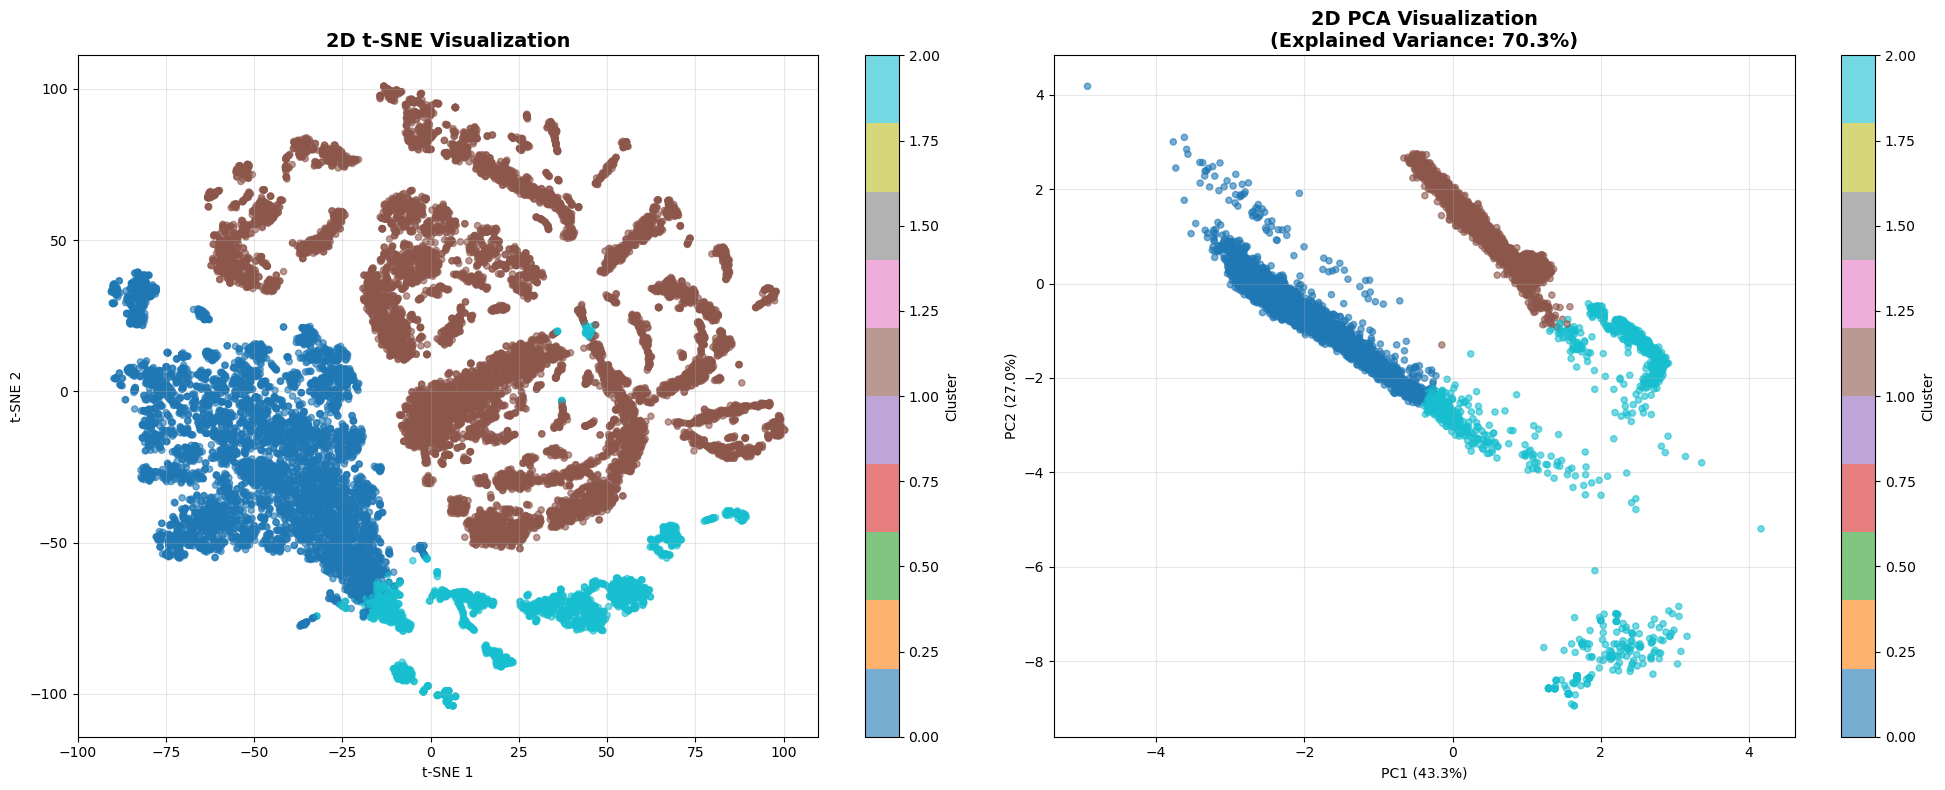

In [22]:
# Create 2D comparison plots
tsne_2d, pca_2d = create_2d_comparison_plots(df_chats, embedding_matrix, sample_size=20000, use_embeddings=True)
